# Column generation approach

## Pre-requisites

In [36]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import cg, config, dataset, layers, pack, plot, superitems, utils, warm_start

<IPython.core.display.Javascript object>

In [19]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [5]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Dataset

In [6]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

In [7]:
ordered_products = 100
order = product_dataset.get_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,131932,228,139,254,26,8049768
3,365838,267,131,322,11,11262594
4,259178,253,191,580,68,28027340


<IPython.core.display.Javascript object>

## Superitems

In [65]:
superitems_pool = superitems.SuperitemPool(
    order=order, pallet_dims=config.PALLET_DIMS, max_vstacked=4
)
superitems_pool.to_dataframe()

Generating horizontal 2-items superitems: 0it [00:00, ?it/s]
Generating horizontal 4-items superitems: 0it [00:00, ?it/s]


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,236,142,437,[1],SingleItemSuperitem
2,228,139,254,[2],SingleItemSuperitem
3,267,131,322,[3],SingleItemSuperitem
4,253,191,580,[4],SingleItemSuperitem
...,...,...,...,...,...
202,307,282,1503,"[69, 77, 79, 95]",VerticalSuperitem
203,340,269,1416,"[19, 30, 39, 44]",VerticalSuperitem
204,273,378,1452,"[40, 45, 49, 72]",VerticalSuperitem
205,268,382,1346,"[33, 54, 60, 87]",VerticalSuperitem


<IPython.core.display.Javascript object>

## Column generation

- Dobbiamo passare a SP solo gli item con dual > 0?
- Dobbiamo evitare di processare layer con alpha != 1 (anche in SP no placement)?
- RMP lavora su tutti i layer, solo su quelli nuovi o su una parte?

### Warm start with height groups

In [66]:
height_groups = warm_start.get_height_groups(superitems_pool, height_tol=5)
for group in height_groups:
    display(group.to_dataframe())

,width,depth,height,ids,type
0,155,205,176,[42],SingleItemSuperitem


,width,depth,height,ids,type
0,178,83,195,[46],SingleItemSuperitem


,width,depth,height,ids,type
0,192,132,201,[65],SingleItemSuperitem


,width,depth,height,ids,type
0,190,91,215,[99],SingleItemSuperitem


,width,depth,height,ids,type
0,176,100,225,[24],SingleItemSuperitem
1,168,173,224,[43],SingleItemSuperitem
2,177,174,226,[55],SingleItemSuperitem
3,123,159,227,[59],SingleItemSuperitem
4,135,130,228,[80],SingleItemSuperitem
5,179,176,225,[81],SingleItemSuperitem
6,140,174,223,[91],SingleItemSuperitem


,width,depth,height,ids,type
0,180,57,234,[23],SingleItemSuperitem
1,163,155,239,[96],SingleItemSuperitem


,width,depth,height,ids,type
0,173,179,248,[25],SingleItemSuperitem
1,234,112,251,[70],SingleItemSuperitem


,width,depth,height,ids,type
0,228,139,254,[2],SingleItemSuperitem
1,234,112,251,[70],SingleItemSuperitem


,width,depth,height,ids,type
0,228,139,254,[2],SingleItemSuperitem
1,188,371,257,[49],SingleItemSuperitem
2,223,136,257,[85],SingleItemSuperitem


,width,depth,height,ids,type
0,218,54,267,[37],SingleItemSuperitem
1,176,98,264,[86],SingleItemSuperitem
2,197,382,268,[87],SingleItemSuperitem


,width,depth,height,ids,type
0,203,154,273,[10],SingleItemSuperitem
1,197,382,268,[87],SingleItemSuperitem


,width,depth,height,ids,type
0,203,154,273,[10],SingleItemSuperitem
1,167,126,274,[13],SingleItemSuperitem
2,165,251,275,[98],SingleItemSuperitem


,width,depth,height,ids,type
0,167,126,274,[13],SingleItemSuperitem
1,226,269,279,[44],SingleItemSuperitem
2,159,92,279,[47],SingleItemSuperitem
3,165,251,275,[98],SingleItemSuperitem


,width,depth,height,ids,type
0,226,269,279,[44],SingleItemSuperitem
1,159,92,279,[47],SingleItemSuperitem
2,187,144,281,[63],SingleItemSuperitem
3,269,144,283,[64],SingleItemSuperitem
4,159,304,281,[71],SingleItemSuperitem


,width,depth,height,ids,type
0,228,207,292,[18],SingleItemSuperitem
1,245,139,292,[31],SingleItemSuperitem
2,238,345,289,[60],SingleItemSuperitem
3,242,109,289,[66],SingleItemSuperitem
4,226,134,290,[89],SingleItemSuperitem


,width,depth,height,ids,type
0,145,271,295,[15],SingleItemSuperitem
1,228,207,292,[18],SingleItemSuperitem
2,245,139,292,[31],SingleItemSuperitem
3,226,134,290,[89],SingleItemSuperitem


,width,depth,height,ids,type
0,143,343,297,[9],SingleItemSuperitem
1,145,271,295,[15],SingleItemSuperitem
2,228,207,292,[18],SingleItemSuperitem
3,245,139,292,[31],SingleItemSuperitem


,width,depth,height,ids,type
0,240,97,304,[68],SingleItemSuperitem


,width,depth,height,ids,type
0,245,168,317,[17],SingleItemSuperitem
1,249,237,318,[30],SingleItemSuperitem
2,213,188,313,[50],SingleItemSuperitem
3,217,244,313,[75],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,245,168,317,[17],SingleItemSuperitem
2,249,237,318,[30],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,148,195,323,[14],SingleItemSuperitem
2,249,237,318,[30],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,148,195,323,[14],SingleItemSuperitem
2,273,257,325,[40],SingleItemSuperitem
3,225,93,327,[62],SingleItemSuperitem


,width,depth,height,ids,type
0,231,176,329,[34],SingleItemSuperitem
1,273,257,325,[40],SingleItemSuperitem
2,225,93,327,[62],SingleItemSuperitem
3,258,127,330,[93],SingleItemSuperitem


,width,depth,height,ids,type
0,231,176,329,[34],SingleItemSuperitem
1,287,157,333,[53],SingleItemSuperitem
2,244,312,333,[54],SingleItemSuperitem
3,258,127,330,[93],SingleItemSuperitem


,width,depth,height,ids,type
0,206,212,337,[12],SingleItemSuperitem
1,287,157,333,[53],SingleItemSuperitem
2,244,312,333,[54],SingleItemSuperitem
3,180,64,336,[88],SingleItemSuperitem


,width,depth,height,ids,type
0,206,212,337,[12],SingleItemSuperitem
1,241,158,342,[32],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[32],SingleItemSuperitem
1,231,128,345,[94],SingleItemSuperitem


,width,depth,height,ids,type
0,202,210,349,[26],SingleItemSuperitem
1,241,231,350,[67],SingleItemSuperitem
2,231,128,345,[94],SingleItemSuperitem


,width,depth,height,ids,type
0,202,210,349,[26],SingleItemSuperitem
1,186,378,351,[45],SingleItemSuperitem
2,239,159,354,[61],SingleItemSuperitem
3,241,231,350,[67],SingleItemSuperitem
4,207,282,352,[69],SingleItemSuperitem


,width,depth,height,ids,type
0,273,214,363,[95],SingleItemSuperitem


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,302,121,376,[78],SingleItemSuperitem
2,235,155,372,[90],SingleItemSuperitem


,width,depth,height,ids,type
0,275,171,380,[76],SingleItemSuperitem
1,302,121,376,[78],SingleItemSuperitem
2,286,191,379,[84],SingleItemSuperitem


,width,depth,height,ids,type
0,249,142,388,[8],SingleItemSuperitem
1,307,187,387,[77],SingleItemSuperitem


,width,depth,height,ids,type
0,249,142,388,[8],SingleItemSuperitem
1,219,205,393,[57],SingleItemSuperitem


,width,depth,height,ids,type
0,245,379,394,[7],SingleItemSuperitem
1,262,148,394,[16],SingleItemSuperitem
2,219,205,393,[57],SingleItemSuperitem
3,239,119,398,[82],SingleItemSuperitem


,width,depth,height,ids,type
0,247,133,403,[38],SingleItemSuperitem
1,284,197,401,[79],SingleItemSuperitem
2,239,119,398,[82],SingleItemSuperitem


,width,depth,height,ids,type
0,304,214,406,[19],SingleItemSuperitem
1,243,102,406,[36],SingleItemSuperitem
2,247,133,403,[38],SingleItemSuperitem
3,284,197,401,[79],SingleItemSuperitem


,width,depth,height,ids,type
0,304,214,406,[19],SingleItemSuperitem
1,343,263,411,[21],SingleItemSuperitem
2,243,102,406,[36],SingleItemSuperitem


,width,depth,height,ids,type
0,343,263,411,[21],SingleItemSuperitem
1,277,192,416,[28],SingleItemSuperitem
2,340,192,413,[39],SingleItemSuperitem


,width,depth,height,ids,type
0,277,192,416,[28],SingleItemSuperitem
1,340,192,413,[39],SingleItemSuperitem
2,339,84,417,[58],SingleItemSuperitem


,width,depth,height,ids,type
0,307,167,422,[41],SingleItemSuperitem
1,339,84,417,[58],SingleItemSuperitem


,width,depth,height,ids,type
0,236,142,437,[1],SingleItemSuperitem
1,279,180,437,[11],SingleItemSuperitem
2,232,494,441,[20],SingleItemSuperitem
3,294,136,440,[22],SingleItemSuperitem
4,350,287,441,[56],SingleItemSuperitem
5,192,155,440,"[65, 96]",VerticalSuperitem


,width,depth,height,ids,type
0,232,494,441,[20],SingleItemSuperitem
1,294,136,440,[22],SingleItemSuperitem
2,300,291,444,[51],SingleItemSuperitem
3,350,287,441,[56],SingleItemSuperitem
4,190,130,443,"[80, 99]",VerticalSuperitem
5,192,155,440,"[65, 96]",VerticalSuperitem


,width,depth,height,ids,type
0,300,291,444,[51],SingleItemSuperitem
1,254,179,448,[92],SingleItemSuperitem
2,190,130,443,"[80, 99]",VerticalSuperitem


,width,depth,height,ids,type
0,286,162,450,[29],SingleItemSuperitem
1,254,179,448,[92],SingleItemSuperitem


,width,depth,height,ids,type
0,268,313,456,[33],SingleItemSuperitem
1,178,98,459,"[46, 86]",VerticalSuperitem


,width,depth,height,ids,type
0,324,98,472,[48],SingleItemSuperitem
1,177,179,474,"[25, 55]",VerticalSuperitem


,width,depth,height,ids,type
0,286,158,481,[5],SingleItemSuperitem
1,318,267,483,[6],SingleItemSuperitem
2,317,110,484,[52],SingleItemSuperitem
3,299,121,486,[97],SingleItemSuperitem


,width,depth,height,ids,type
0,318,267,483,[6],SingleItemSuperitem
1,363,151,487,[35],SingleItemSuperitem
2,317,110,484,[52],SingleItemSuperitem
3,299,121,486,[97],SingleItemSuperitem


,width,depth,height,ids,type
0,203,176,498,"[10, 81]",VerticalSuperitem


,width,depth,height,ids,type
0,281,69,510,[74],SingleItemSuperitem
1,258,205,506,"[42, 93]",VerticalSuperitem


,width,depth,height,ids,type
0,225,318,519,[72],SingleItemSuperitem


,width,depth,height,ids,type
0,242,112,540,"[66, 70]",VerticalSuperitem


,width,depth,height,ids,type
0,218,92,546,"[37, 47]",VerticalSuperitem
1,226,136,547,"[85, 89]",VerticalSuperitem


,width,depth,height,ids,type
0,225,159,554,"[59, 62]",VerticalSuperitem


,width,depth,height,ids,type
0,180,64,570,"[23, 88]",VerticalSuperitem
1,231,173,569,"[43, 94]",VerticalSuperitem


,width,depth,height,ids,type
0,253,191,580,[4],SingleItemSuperitem
1,240,126,578,"[13, 68]",VerticalSuperitem
2,273,371,582,"[40, 49]",VerticalSuperitem


,width,depth,height,ids,type
0,443,76,593,[83],SingleItemSuperitem
1,245,251,592,"[17, 98]",VerticalSuperitem
2,249,269,597,"[30, 44]",VerticalSuperitem


,width,depth,height,ids,type
0,347,335,601,[73],SingleItemSuperitem
1,249,269,597,"[30, 44]",VerticalSuperitem
2,244,382,601,"[54, 87]",VerticalSuperitem


,width,depth,height,ids,type
0,243,174,629,"[36, 91]",VerticalSuperitem


,width,depth,height,ids,type
0,231,188,642,"[34, 50]",VerticalSuperitem


,width,depth,height,ids,type
0,366,256,654,[27],SingleItemSuperitem


,width,depth,height,ids,type
0,275,207,672,"[18, 76]",VerticalSuperitem
1,190,130,668,"[24, 80, 99]",VerticalSuperitem


,width,depth,height,ids,type
0,269,148,677,"[16, 64]",VerticalSuperitem
1,275,207,672,"[18, 76]",VerticalSuperitem


,width,depth,height,ids,type
0,239,144,679,"[63, 82]",VerticalSuperitem
1,269,148,677,"[16, 64]",VerticalSuperitem


,width,depth,height,ids,type
0,241,159,696,"[32, 61]",VerticalSuperitem


,width,depth,height,ids,type
0,202,221,720,"[0, 26]",VerticalSuperitem
1,273,282,715,"[69, 95]",VerticalSuperitem


,width,depth,height,ids,type
0,324,139,726,"[2, 48]",VerticalSuperitem
1,219,212,730,"[12, 57]",VerticalSuperitem
2,223,179,731,"[25, 55, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,281,100,735,"[24, 74]",VerticalSuperitem
1,294,271,735,"[15, 22]",VerticalSuperitem
2,219,212,730,"[12, 57]",VerticalSuperitem
3,279,343,734,"[9, 11]",VerticalSuperitem
4,307,244,735,"[41, 75]",VerticalSuperitem
5,223,179,731,"[25, 55, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,281,100,735,"[24, 74]",VerticalSuperitem
1,294,271,735,"[15, 22]",VerticalSuperitem
2,279,343,734,"[9, 11]",VerticalSuperitem
3,307,244,735,"[41, 75]",VerticalSuperitem
4,178,98,738,"[46, 47, 86]",VerticalSuperitem


,width,depth,height,ids,type
0,281,100,735,"[24, 74]",VerticalSuperitem
1,339,195,740,"[14, 58]",VerticalSuperitem
2,294,271,735,"[15, 22]",VerticalSuperitem
3,307,244,735,"[41, 75]",VerticalSuperitem
4,178,98,738,"[46, 47, 86]",VerticalSuperitem


,width,depth,height,ids,type
0,339,195,740,"[14, 58]",VerticalSuperitem
1,268,345,745,"[33, 60]",VerticalSuperitem


,width,depth,height,ids,type
0,302,155,748,"[78, 90]",VerticalSuperitem
1,268,345,745,"[33, 60]",VerticalSuperitem


,width,depth,height,ids,type
0,302,155,748,"[78, 90]",VerticalSuperitem
1,228,176,752,"[2, 10, 81]",VerticalSuperitem


,width,depth,height,ids,type
0,307,197,788,"[77, 79]",VerticalSuperitem


,width,depth,height,ids,type
0,286,192,795,"[28, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,317,131,806,"[3, 52]",VerticalSuperitem
1,343,379,805,"[7, 21]",VerticalSuperitem
2,240,174,801,"[13, 68, 91]",VerticalSuperitem


,width,depth,height,ids,type
0,287,158,814,"[5, 53]",VerticalSuperitem
1,340,214,819,"[19, 39]",VerticalSuperitem


,width,depth,height,ids,type
0,340,214,819,"[19, 39]",VerticalSuperitem
1,242,144,821,"[63, 66, 70]",VerticalSuperitem


,width,depth,height,ids,type
0,247,142,840,"[1, 38]",VerticalSuperitem
1,363,231,837,"[35, 67]",VerticalSuperitem
2,218,64,837,"[23, 37, 88]",VerticalSuperitem


,width,depth,height,ids,type
0,243,155,846,"[36, 65, 96]",VerticalSuperitem


,width,depth,height,ids,type
0,253,304,861,"[4, 71]",VerticalSuperitem
1,231,173,859,"[43, 89, 94]",VerticalSuperitem


,width,depth,height,ids,type
0,299,142,874,"[8, 97]",VerticalSuperitem
1,225,378,870,"[45, 72]",VerticalSuperitem


,width,depth,height,ids,type
0,443,139,885,"[31, 83]",VerticalSuperitem


,width,depth,height,ids,type
0,286,179,898,"[29, 92]",VerticalSuperitem
1,190,130,902,"[46, 80, 86, 99]",VerticalSuperitem


,width,depth,height,ids,type
0,318,291,927,"[6, 51]",VerticalSuperitem


,width,depth,height,ids,type
0,273,378,933,"[40, 45, 49]",VerticalSuperitem


,width,depth,height,ids,type
0,245,251,941,"[17, 26, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,269,271,972,"[15, 16, 64]",VerticalSuperitem
1,203,179,972,"[10, 25, 55, 81]",VerticalSuperitem


,width,depth,height,ids,type
0,324,205,978,"[42, 48, 93]",VerticalSuperitem
1,242,155,980,"[65, 66, 70, 96]",VerticalSuperitem


,width,depth,height,ids,type
0,273,282,1033,"[30, 69, 95]",VerticalSuperitem


,width,depth,height,ids,type
0,347,494,1042,"[20, 73]",VerticalSuperitem


,width,depth,height,ids,type
0,281,159,1064,"[59, 62, 74]",VerticalSuperitem


,width,depth,height,ids,type
0,302,159,1072,"[32, 61, 78]",VerticalSuperitem


,width,depth,height,ids,type
0,294,188,1082,"[22, 34, 50]",VerticalSuperitem


,width,depth,height,ids,type
0,366,287,1095,"[27, 56]",VerticalSuperitem
1,317,139,1098,"[3, 31, 52]",VerticalSuperitem
2,340,269,1098,"[19, 39, 44]",VerticalSuperitem


,width,depth,height,ids,type
0,317,139,1098,"[3, 31, 52]",VerticalSuperitem
1,219,221,1101,"[0, 12, 57]",VerticalSuperitem
2,340,269,1098,"[19, 39, 44]",VerticalSuperitem


,width,depth,height,ids,type
0,244,382,1120,"[54, 72, 87]",VerticalSuperitem
1,218,92,1116,"[23, 37, 47, 88]",VerticalSuperitem
2,231,173,1116,"[43, 85, 89, 94]",VerticalSuperitem


,width,depth,height,ids,type
0,286,207,1122,"[18, 29, 76]",VerticalSuperitem
1,244,382,1120,"[54, 72, 87]",VerticalSuperitem


,width,depth,height,ids,type
0,339,195,1138,"[14, 58, 82]",VerticalSuperitem
1,307,231,1138,"[67, 77, 79]",VerticalSuperitem


,width,depth,height,ids,type
0,253,343,1158,"[4, 9, 71]",VerticalSuperitem


,width,depth,height,ids,type
0,307,244,1172,"[11, 41, 75]",VerticalSuperitem


,width,depth,height,ids,type
0,243,174,1207,"[13, 36, 68, 91]",VerticalSuperitem


,width,depth,height,ids,type
0,318,345,1228,"[6, 33, 60]",VerticalSuperitem
1,324,205,1232,"[2, 42, 48, 93]",VerticalSuperitem


,width,depth,height,ids,type
0,324,205,1232,"[2, 42, 48, 93]",VerticalSuperitem
1,245,251,1234,"[17, 34, 50, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,299,155,1246,"[8, 90, 97]",VerticalSuperitem
1,343,379,1249,"[7, 21, 51]",VerticalSuperitem


,width,depth,height,ids,type
0,287,179,1262,"[5, 53, 92]",VerticalSuperitem


,width,depth,height,ids,type
0,363,192,1282,"[28, 35, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,281,159,1289,"[24, 59, 62, 74]",VerticalSuperitem


,width,depth,height,ids,type
0,268,382,1346,"[33, 54, 60, 87]",VerticalSuperitem


,width,depth,height,ids,type
0,294,271,1412,"[15, 16, 22, 64]",VerticalSuperitem
1,340,269,1416,"[19, 30, 39, 44]",VerticalSuperitem


,width,depth,height,ids,type
0,339,195,1419,"[14, 58, 63, 82]",VerticalSuperitem
1,340,269,1416,"[19, 30, 39, 44]",VerticalSuperitem


,width,depth,height,ids,type
0,443,142,1433,"[1, 38, 83]",VerticalSuperitem


,width,depth,height,ids,type
0,302,159,1444,"[32, 61, 78, 90]",VerticalSuperitem


,width,depth,height,ids,type
0,219,221,1450,"[0, 12, 26, 57]",VerticalSuperitem
1,273,378,1452,"[40, 45, 49, 72]",VerticalSuperitem


,width,depth,height,ids,type
0,307,343,1469,"[9, 11, 41, 75]",VerticalSuperitem


,width,depth,height,ids,type
0,307,282,1503,"[69, 77, 79, 95]",VerticalSuperitem


,width,depth,height,ids,type
0,366,494,1536,"[20, 27, 56]",VerticalSuperitem
1,275,304,1533,"[4, 18, 71, 76]",VerticalSuperitem


,width,depth,height,ids,type
0,363,231,1632,"[28, 35, 67, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,317,142,1680,"[3, 8, 52, 97]",VerticalSuperitem


,width,depth,height,ids,type
0,287,179,1712,"[5, 29, 53, 92]",VerticalSuperitem


,width,depth,height,ids,type
0,443,142,1725,"[1, 31, 38, 83]",VerticalSuperitem


,width,depth,height,ids,type
0,343,379,1732,"[6, 7, 21, 51]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [74]:
bins_lbs = []
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for spool in height_groups:
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS)
    layer_pool, bins_lb = cg.column_generation(
        layer_pool,
        config.PALLET_DIMS,
        max_iter=100,
        tlim=None,
    )
    final_layer_pool.extend(layer_pool)
    bins_lbs.append(bins_lb)
final_layer_pool.to_dataframe()

  0%|          | 0/100 [00:00<?, ?it/s]

Solving RMP...
Duals: [176.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [195.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [201.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [215.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.  -0.  -0. 228.  -0.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0. 239.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0. 251.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [  3. 251.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergen

  0%|          | 0/100 [00:00<?, ?it/s]

 0.0
Reached convergence :)
Solving RMP...
Duals: [  3.  -0. 327.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: -1.0
Solving SP (with placement)...
Solving RMP...
Duals: [  2.   1. 327.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Solving SP (no placement)...
Reduced cost: -1.0
Solving SP (with placement)...
Solving RMP...
Duals: [  2.  -0. 327.   1.]
Alpha: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0. 333.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [  4.  -0. 333.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0. 342.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0. 345.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no place

  0%|          | 0/100 [00:00<?, ?it/s]

Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [  5.  -0. 398.]
Alpha: [0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [  3.  -0. 403.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [  5.  -0. 406.]
Alpha: [0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: -5.0
Solving SP (with placement)...
Solving RMP...
Duals: [ -0.   5. 406.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [  3.  -0. 413.]
Alpha: [0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: -3.0
Solving SP (with placement)...
Solving RMP...
Duals: [ -0.   3. 413.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0. 417.]
Alpha: [0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Red

  9%|▉         | 9/100 [00:00<00:01, 81.58it/s]

 [  2.  -0.   3. 443.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0]
Solving SP (no placement)...
Reduced cost: -1.0
Solving SP (with placement)...
Solving RMP...
Duals: [  2.  -0.   3. 443.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reduced cost: -1.0
Solving SP (with placement)...
Solving RMP...
Duals: [  2.  -0.   3. 443.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reduced cost: -1.0
Solving SP (with placement)...
Solving RMP...
Duals: [  2.  -0.   3. 443.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reduced cost: -1.0
Solving SP (with placement)...
Solving RMP...
Duals: [  2.  -0.   3. 443.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reduced cost: -1.0
Solving SP (with placement)...
Solving RMP...
Duals: [  2.  -0.   3. 443.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reduced cost: -1.0
Solving SP (with placement)...
Solving RM

  0%|          | 0/100 [00:00<?, ?it/s]


Duals: [  2.  -0.   3. 443.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reduced cost: -1.0
Solving SP (with placement)...
Solving RMP...
Duals: [  2.  -0.   3. 443.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reduced cost: -1.0
Solving SP (with placement)...
Solving RMP...
Duals: [  2.  -0.   3. 443.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reduced cost: -1.0
Solving SP (with placement)...
Solving RMP...
Duals: [  2.  -0.   3. 443.]
Solving RMP...
Duals: [  2. 448.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0. 459.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached con

  0%|          | 0/100 [00:00<?, ?it/s]

 0.0
Reached convergence :)
Solving RMP...
Duals: [554.  -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.   1. 569.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [  4.  -0.  -0.  -0. 578.]
Alpha: [0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: -2.0
Solving SP (with placement)...
Solving RMP...
Duals: [  2.  -0.  -0.   2. 578.]
Alpha: [0.0, 0.0, 0.0, 1.0, 0.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.   5.  -0. 592.]
Alpha: [0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.  -0.  -0. 601.]
Alpha: [0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [629.  -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)

  0%|          | 0/100 [00:00<?, ?it/s]

Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.   5.  -0.  -0.  -0.  -0.  -0.  -0. 735.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: -5.0
Solving SP (with placement)...
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.   5.  -0. 735.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.  -0. 745.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.  -0. 748.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.  -0.   4. 748.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [788.  -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [795.  -0.]
Alph

  0%|          | 0/100 [00:00<?, ?it/s]

 0.0
Reached convergence :)
Solving RMP...
Duals: [933.  -0.  -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [941.  -0.  -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0. 972.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0. 980.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [1033.   -0.   -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [1042.   -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [1064.   -0.   -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [1072.   -0.   -0.]
Alpha: [1.0]


  0%|          | 0/100 [00:00<?, ?it/s]



Reached convergence :)
Solving RMP...
Duals: [  -0.   -0.   -0.   -0.   -0.   -0.   -0. 1419.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [1433.   -0.   -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [1444.   -0.   -0.   -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [  -0.   -0.   -0.   -0.   -0.   -0.   -0. 1452.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [1469.   -0.   -0.   -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [1503.   -0.   -0.   -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [  -0.   -0.   -0.   -0.    3.   -0. 1533.]
Alpha: [0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced co

,item,x,y,z,layer
0,42,0,0,0,0
1,46,0,0,0,1
2,65,0,0,0,2
3,99,0,0,0,3
4,24,0,0,0,4
...,...,...,...,...,...
1028,31,0,0,1433,408
1029,6,0,0,0,409
1030,51,0,0,483,409
1031,21,0,0,927,409


<IPython.core.display.Javascript object>

In [55]:
np.floor(np.mean(bins_lbs) / config.max_product_height)

0.0

In [50]:
utils.get_l0_lb(order, config.pallet_lenght, config.pallet_width, config.max_product_height)

3.0

In [51]:
utils.get_l1_lb(order, config.pallet_lenght, config.pallet_width, config.max_product_height)

(2.0, 2.0, 0.0, 0.0)

In [40]:
utils.get_l2_lb(order, config.pallet_lenght, config.pallet_width, config.max_product_height)

  2%|▏         | 4892/240000 [00:28<22:42, 172.59it/s]


KeyboardInterrupt: 

In [90]:
bins = pack.construct_bins(
    final_layer_pool, config.PALLET_DIMS, min_density=0.5, two_dims=False
)
bins

{0: [Layer(height=228, ids=[80]),
  Layer(height=227, ids=[59]),
  Layer(height=226, ids=[55]),
  Layer(height=224, ids=[43]),
  Layer(height=225, ids=[24]),
  Layer(height=215, ids=[99]),
  Layer(height=201, ids=[65]),
  Layer(height=195, ids=[46]),
  Layer(height=176, ids=[42])],
 1: [Layer(height=251, ids=[70]),
  Layer(height=254, ids=[2]),
  Layer(height=251, ids=[70]),
  Layer(height=248, ids=[25]),
  Layer(height=239, ids=[96]),
  Layer(height=234, ids=[23]),
  Layer(height=223, ids=[91]),
  Layer(height=225, ids=[81])],
 2: [Layer(height=273, ids=[10]),
  Layer(height=268, ids=[87]),
  Layer(height=264, ids=[86]),
  Layer(height=267, ids=[37]),
  Layer(height=257, ids=[85]),
  Layer(height=257, ids=[49]),
  Layer(height=254, ids=[2])],
 3: [Layer(height=279, ids=[47]),
  Layer(height=279, ids=[44]),
  Layer(height=274, ids=[13]),
  Layer(height=275, ids=[98]),
  Layer(height=274, ids=[13]),
  Layer(height=273, ids=[10]),
  Layer(height=268, ids=[87])],
 4: [Layer(height=292, id

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


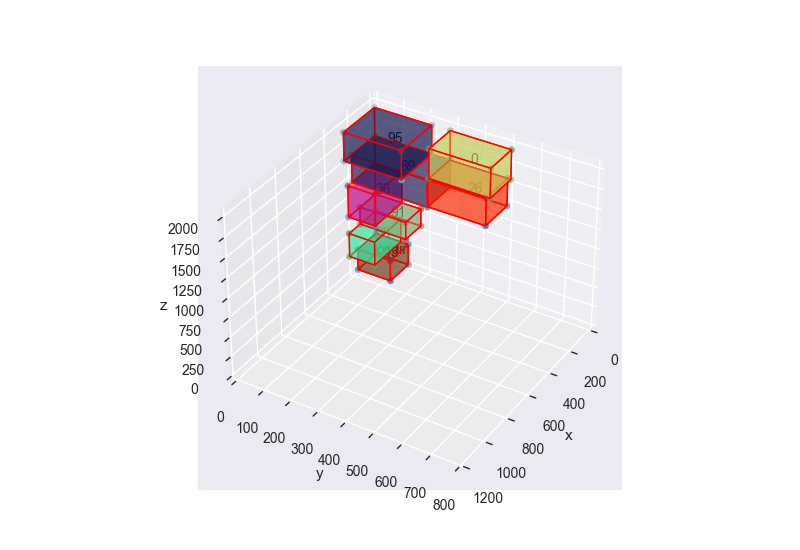

<IPython.core.display.Javascript object>

In [95]:
example_bin = bins[173]
height = 0
ax = plot.get_pallet(config.PALLET_DIMS)
for layer in example_bin:
    items_coords = layer.get_items_coords(z=height)
    for item_id, coords in items_coords.items():
        dims = (
            order.iloc[item_id].width,
            order.iloc[item_id].depth,
            order.iloc[item_id].height,
        )
        ax = plot.add_product_to_pallet(
            ax, item_id, (coords.x, coords.y, coords.z), dims
        )
    height += layer.height
plt.show()

Todo:
- Verificare se superitem con stessi item possono essere nello stesso layer (sia in CP che maxrects)
    - Solo fra superitem con > 1 item e superitem con = 1 item
- We also let each selected layer to have a maximum of 3 items that are covered using the previously selected layers.
    - Forse non serve per come abbiamo strutturato layer e superitem
- (?) To ensure that each item is covered only once, we keep the items that are covered multiple times only in the layer with the highest αl value, and remove them from the rest of the selected layers
    - Aggiungere alpha value nei layer
- Come gestire oggetti volanti?
    - Spaziatura spiegata nel paper?
- Provare superitems orizzontali: stesso item duplicato stesso layer
- Controllare ordinamento per densita nella layer pool (select_layers)

## Warm start without height groups

In [141]:
zsl, ol = warm_start.warm_start_no_groups(
    superitems, config.pallet_lenght, config.pallet_width
)
zsl, ol

(array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],


In [140]:
zsl, ol = warm_start.warm_start(
    len(superitems), initial_groups, config.pallet_lenght, config.pallet_width
)
zsl, ol

IndexError: index 91 is out of bounds for axis 0 with size 60

In [142]:
fsi = layers.items_assignment(superitems)
fsi

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [ ]:
layer_pool = column_generation(
    fsi, zsl, ol, ws, ds, hs, 
    config.pallet_lenght, config.pallet_width, tlim=None
)


  0%|          | 0/20 [00:00<?, ?it/s]

Solving RMP...


In [95]:
layer_pool

[(1.0,
  1097.0000000000002,
  array([ 2, 14, 19, 31]),
  array([[  0.,   0.],
         [  0., 118.],
         [240., 494.],
         [ 84., 494.]])),
 (1.0,
  756.0000000000001,
  array([ 1,  4,  7, 20, 21, 24]),
  array([[ 19.,   0.],
         [152., 499.],
         [  0., 254.],
         [ 19., 254.],
         [304., 254.],
         [  0., 109.]])),
 (1.0, 232.0, array([8]), array([[0., 0.]])),
 (0.5,
  1619.9999999999998,
  array([ 9, 12, 27, 29]),
  array([[  0., 894.],
         [563.,   0.],
         [  0., 549.],
         [  0.,  87.]])),
 (0.5,
  1019.0000000000001,
  array([10, 16, 26, 28]),
  array([[  0.,   0.],
         [  0., 747.],
         [628.,   0.],
         [ 21.,   0.]])),
 (0.5,
  1543.0000000000002,
  array([13, 30]),
  array([[  0.,   0.],
         [160.,   0.]])),
 (0.3333333333333333,
  356.99999999999994,
  array([ 6, 22, 25]),
  array([[  0., 184.],
         [  0.,   0.],
         [  0., 368.]]))]

<IPython.core.display.Javascript object>


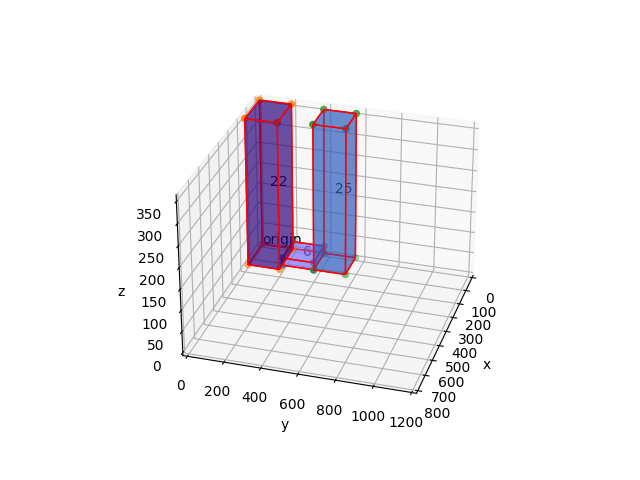

In [104]:
example = layer_pool[6]
ax = plot.get_pallet(config.pallet_lenght, config.pallet_width, example[1])
for s_id, s_coords in zip(example[2], example[3]):
    dims = superitems.iloc[s_id].lenght, superitems.iloc[s_id].width, superitems.iloc[s_id].height
    ax = plot.add_product_to_pallet(ax, s_id, (s_coords[0], s_coords[1], 0), dims)
    plt.show()